- https://medium.com/@vanillaxiangshuyang/self-supervised-learning-on-tabular-data-with-tabnet-544b3ec85cee
- https://colab.research.google.com/drive/1P8Obe07DP3VeOld08ThyT1HnChLip_LO#scrollTo=gvy9vUUNOP0W

- https://www.kaggle.com/code/sisharaneranjana/semi-supervised-pre-training-with-tabnet#%F0%9F%94%8FDescription-of-the-dataset-
- https://dacon.io/en/codeshare/3837

In [1]:
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')

In [2]:
# 원본 데이터
data = pd.read_csv("./dataset/generated/data5.csv")

# 데이터 전처리

In [3]:
df = data.copy()

# Time 을 일중 시간으로 변환
df.loc[:, "Time"] = df.loc[:, "Time"].apply(lambda x : x / 3600 % 24)

# Amount column 은 편차가 크므로 log-scale 로 변환
df['Amount'] = np.log(df.pop('Amount') + 0.001)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


# train_test_split

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
features = df.values
labels = np.array(df.pop('Class'))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.5, random_state=0, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

print("X train shape: ", X_train.shape)
print("Y train shape: ", y_train.shape)
print("===============")
print("X validation shape: ", X_val.shape)
print("y validation shape: ", y_val.shape)
print("===============")
print("X test shape: ", X_test.shape)
print("Y test shape: ", y_test.shape)

X train shape:  (71434, 31)
Y train shape:  (71434,)
X validation shape:  (71435, 31)
y validation shape:  (71435,)
X test shape:  (142870, 31)
Y test shape:  (142870,)


In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val= sc.transform(X_val)

# Network parameters

- https://github.com/dreamquark-ai/tabnet
- https://github.com/dreamquark-ai/tabnet/blob/develop/pretraining_example.ipynb

In [8]:
import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier

In [9]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
#     cat_idxs=cat_idxs,
#     cat_dims=cat_dims,
#     cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

# Self Supervised Training

In [10]:
max_epochs = 100

In [11]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_val],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
)

epoch 0  | loss: 1.60572 | val_0_unsup_loss_numpy: 1.0039900541305542|  0:00:06s
epoch 5  | loss: 0.94774 | val_0_unsup_loss_numpy: 1.022510051727295|  0:00:47s

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 0.9675599932670593


In [12]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_val)
assert(reconstructed_X.shape==embedded_X.shape)

In [13]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_val)

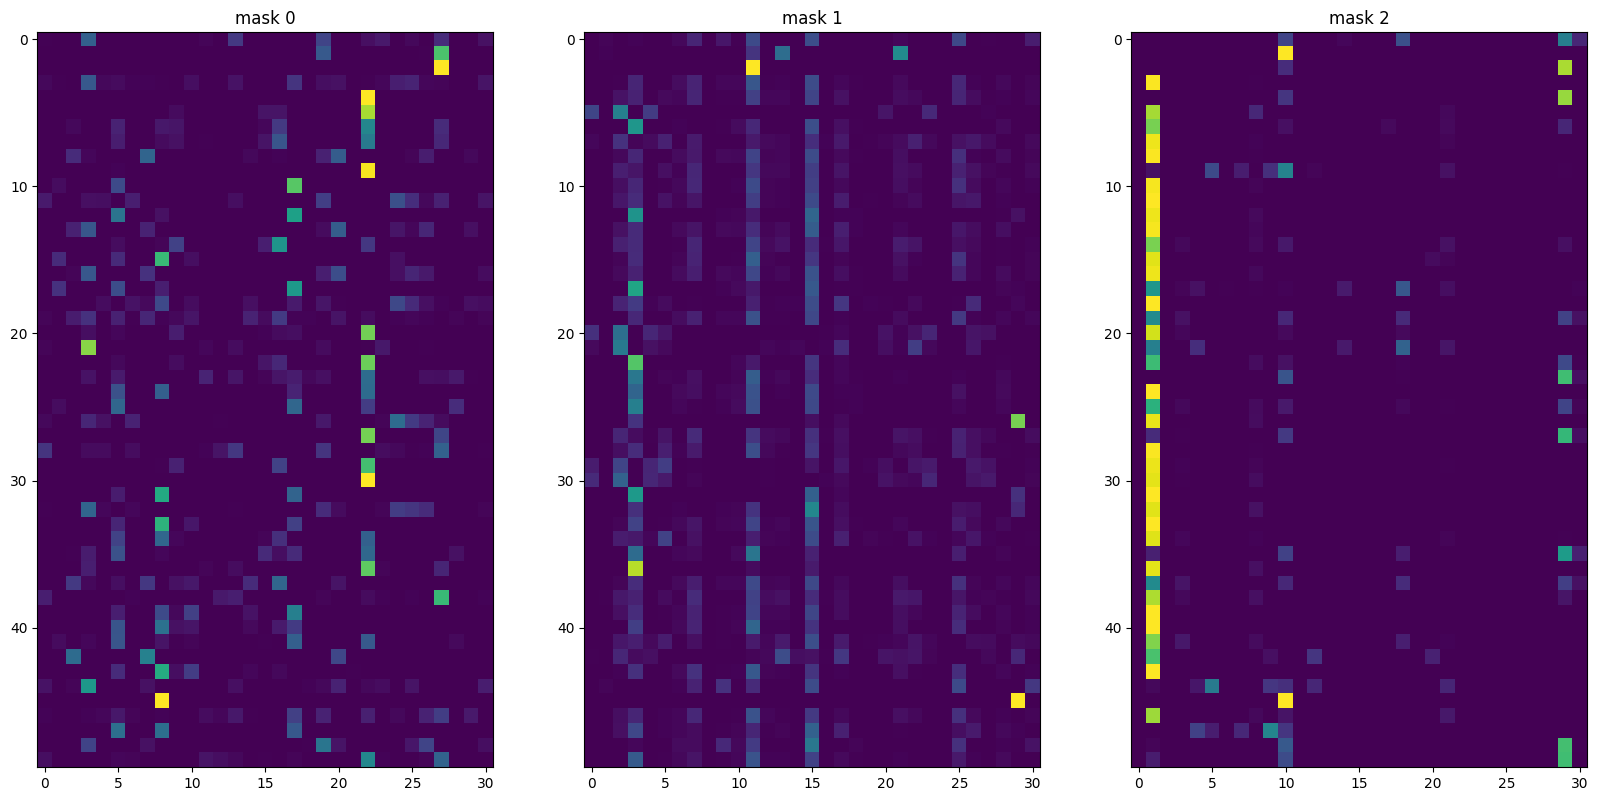

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")

# Save and load the same way as other TabNet models

In [15]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Successfully saved model at ./test_pretrain.zip


# Training

In [16]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax', # This will be overwritten if using pretrain model
                       verbose=5,
                      )

In [17]:
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import f1_score

class F1_Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True

    def __call__(self, y_true, y_score):
        score = f1_score(y_true, (y_score[:, 1]>0.5)*1)
        return score

In [18]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','f1'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain,
    
) 

epoch 0  | loss: 0.32612 | train_logloss: 0.20128 | train_f1: 0.191   | valid_logloss: 0.20318 | valid_f1: 0.20427 |  0:00:10s
epoch 5  | loss: 0.00337 | train_logloss: 0.0023  | train_f1: 0.95933 | valid_logloss: 0.00275 | valid_f1: 0.9546  |  0:00:57s
epoch 10 | loss: 0.00176 | train_logloss: 0.0003  | train_f1: 0.99708 | valid_logloss: 0.00067 | valid_f1: 0.9906  |  0:01:50s
epoch 15 | loss: 0.00119 | train_logloss: 0.00042 | train_f1: 0.98987 | valid_logloss: 0.00088 | valid_f1: 0.98795 |  0:02:39s
epoch 20 | loss: 0.00086 | train_logloss: 0.00025 | train_f1: 0.99419 | valid_logloss: 0.00072 | valid_f1: 0.9906  |  0:03:29s
epoch 25 | loss: 0.00074 | train_logloss: 0.00035 | train_f1: 0.99563 | valid_logloss: 0.00089 | valid_f1: 0.9906  |  0:04:16s
epoch 30 | loss: 0.00065 | train_logloss: 6e-05   | train_f1: 0.99854 | valid_logloss: 0.00038 | valid_f1: 0.99595 |  0:05:02s
epoch 35 | loss: 0.00056 | train_logloss: 4e-05   | train_f1: 0.99854 | valid_logloss: 0.00028 | valid_f1: 0.99

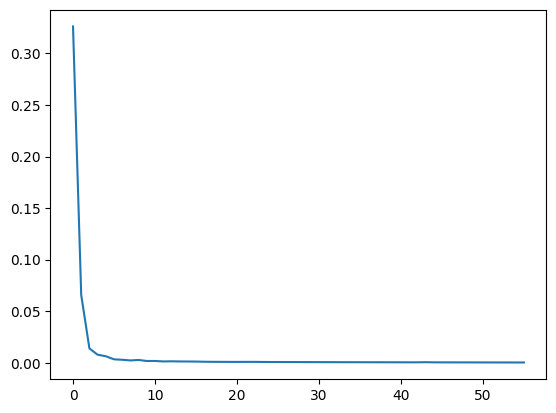

In [19]:
# plot losses
plt.plot(clf.history['loss'])

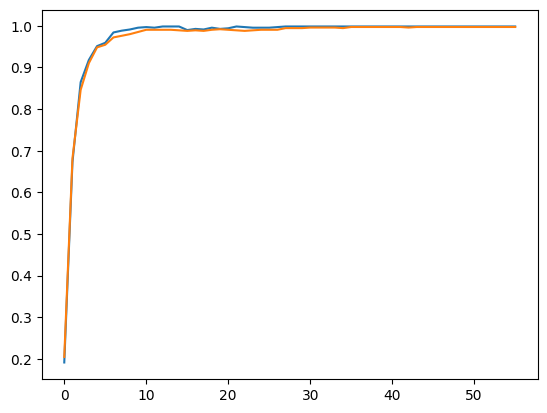

In [20]:
# plot auc
plt.plot(clf.history['train_f1'])
plt.plot(clf.history['valid_f1'])

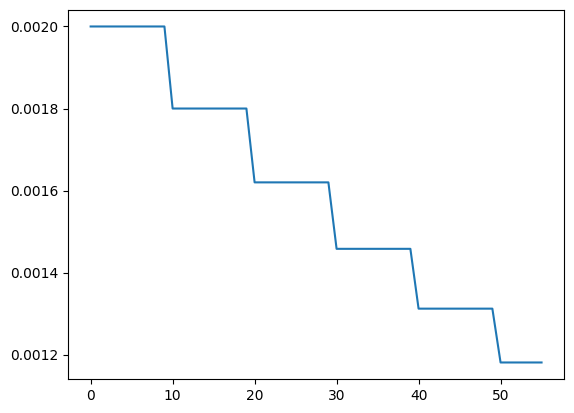

In [21]:
# plot learning rates
plt.plot(clf.history['lr'])

# Predictions

In [22]:
# preds = clf.predict_proba(X_test)
preds = clf.predict(X_test)
test_f1 = f1_score(preds, y_test)

preds_val = clf.predict(X_val)
valid_f1 = f1_score(preds_val, y_val)

print("BEST VALID SCORE : ", clf.best_cost)
print("FINAL TEST SCORE : ", test_f1)

BEST VALID SCORE :  0.9972972972972973
FINAL TEST SCORE :  0.9937018894331702


In [23]:
# check that best weights are used
assert np.isclose(valid_f1, np.max(clf.history['valid_f1']), atol=1e-6)

# Save and load Model

In [24]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [25]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

In [26]:
# loaded_preds = loaded_clf.predict_proba(X_test)
loaded_preds = loaded_clf.predict(X_test)
loaded_test_f1 = f1_score(loaded_preds, y_test)

print("FINAL TEST SCORE : ",loaded_test_f1)

FINAL TEST SCORE :  0.9937018894331702


In [27]:
assert(test_f1 == loaded_test_f1)

# Global explainability : feat importance summing to 

In [28]:
clf.feature_importances_

array([8.55780764e-03, 3.24024965e-01, 1.79265930e-03, 1.05269754e-01,
       4.85482663e-04, 3.13904313e-04, 5.60485519e-04, 8.39164095e-04,
       9.14930864e-04, 1.68890567e-04, 9.72859703e-03, 2.89915886e-01,
       2.45464647e-05, 1.02840871e-03, 1.70643496e-02, 4.22980026e-03,
       1.03089425e-02, 3.71648234e-03, 1.14404909e-03, 1.57218987e-02,
       4.22055730e-05, 1.62229190e-04, 8.77270777e-04, 2.91533773e-04,
       6.92980649e-04, 3.80033500e-03, 1.00714186e-03, 7.45105226e-04,
       1.26790953e-03, 1.95285055e-01, 1.72286494e-05])

# Local explainability and masks

In [29]:
explain_matrix, masks = clf.explain(X_test)

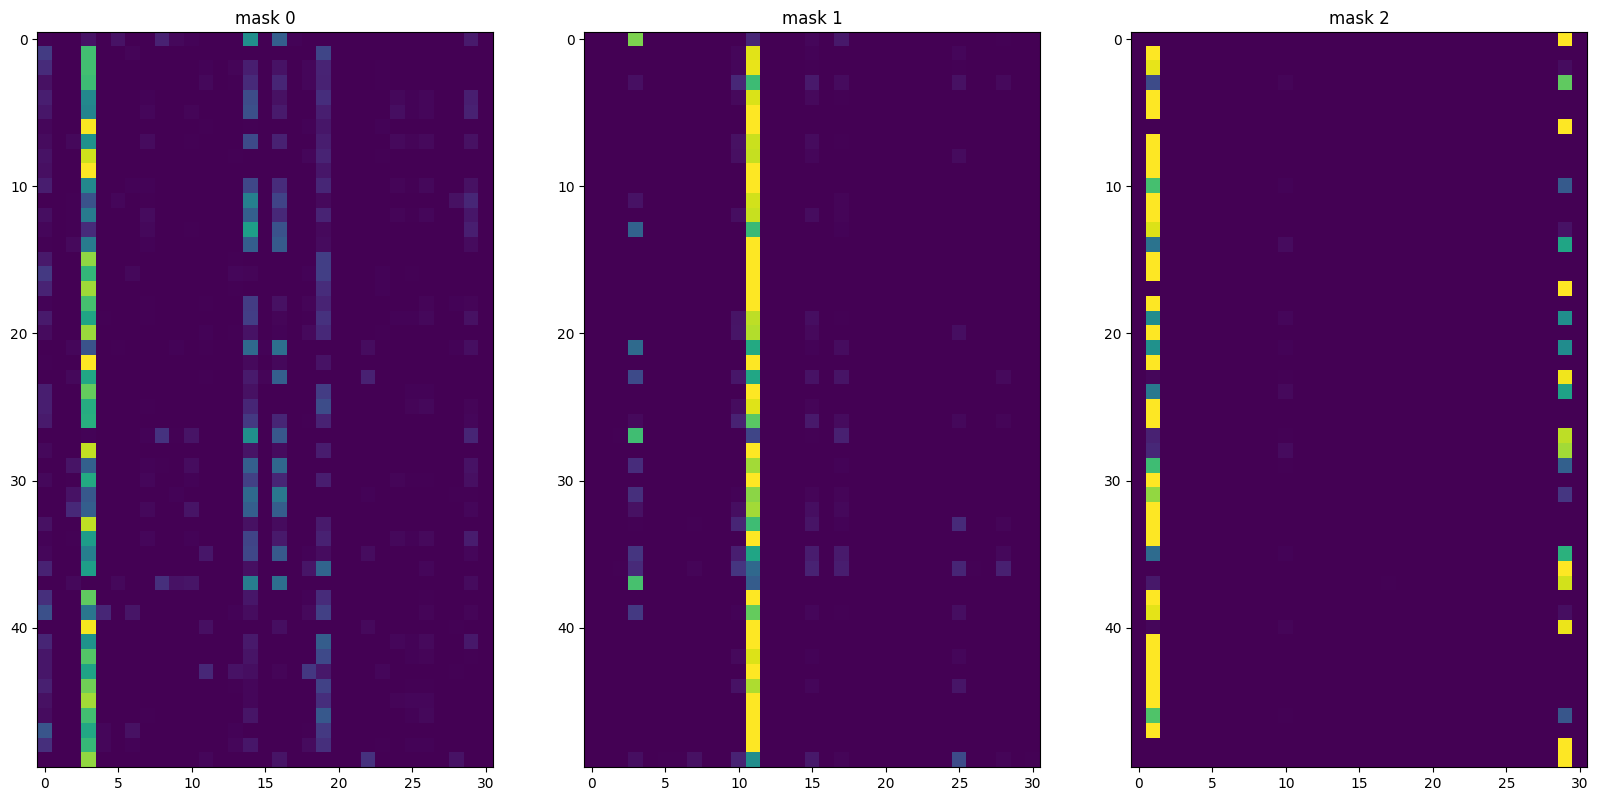

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")